In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.nn import functional as F
import random

model_name = 'flax-community/papuGaPT2'
device = 'cuda'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [2]:
class TokenTrie(dict):
	def __init__(self, sequences=[]):
		self.terminal = False
		for sequence in sequences:
			self.insert(sequence)

	def insert(self, sequence):
		if not sequence:
			self.terminal = True
			return self

		prefix, suffix = sequence[0], sequence[1:]
		if prefix in self:
			self[prefix].insert(suffix)
		else:
			self[prefix] = TokenTrie().insert(suffix)
		return self

In [3]:
class WordGenerator:
	def __init__(self, model, tokenizer, words: list[str]):
		self.model = model
		self.tokenizer = tokenizer
		self.trie = TokenTrie([tokenizer(word).input_ids for word in words])

	def restricted_sampling(self, input_ids, whitelist: list[int]):
		with torch.no_grad():
			outputs = self.model(torch.Tensor([input_ids]).long().to(device))
			next_token_logits = outputs.logits[:, -1, :]  # Get logits for the last token

		probs = F.softmax(next_token_logits, dim=-1).squeeze()
		probs[~torch.isin(
			torch.arange(len(probs)),
			torch.tensor(whitelist)
		)] = 0
		probs /= probs.sum()
		return torch.multinomial(probs, num_samples=1).item()

	def __call__(self, prefix: str):
		prefix += " "
		input_ids = self.tokenizer(prefix)["input_ids"]
		trie = self.trie

		while (whitelist := list(trie.keys())):
			sampled_token = self.restricted_sampling(input_ids, whitelist)
			input_ids.append(sampled_token)
			trie = trie[sampled_token]
		return tokenizer.decode(input_ids).removeprefix(prefix)

2024-11-03 22:31:15.792034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 22:31:15.804384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 22:31:15.807982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 22:31:15.817962: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 22:31:16.687447: W tensorflow/compiler/tf2

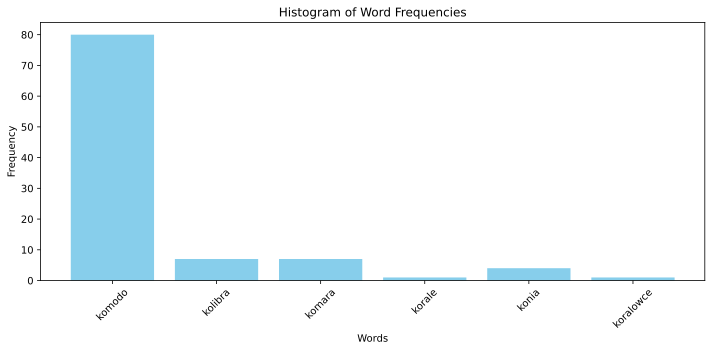

In [5]:
generator = WordGenerator(model, tokenizer, ["koalę", "konia", "kozę", "kolibra", "komara", "komodo", "konika", "korale", "koralowce"])
word_counts = Counter([generator("ala ma") for i in range(100)])
labels, counts = zip(*word_counts.items())  # Unzip into labels and counts

plt.figure(figsize=(10, 5))  # Set the figure size
plt.bar(labels, counts, color='skyblue')  # Create a bar plot
plt.xlabel('Words')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.title('Histogram of Word Frequencies')  # Title of the histogram
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Show the plot